# Package Load

In [1]:
# Base & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

# Oversampling
from imblearn.combine import  SMOTETomek

# Modeling
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

# BayesianOptimizer
from bayes_opt import BayesianOptimization

# Saving Model
import joblib

# Data Load

In [2]:
train = pd.read_csv('data/part/one-hot_encoding/iterative/oversampling/part_one_iter_tomek_train.csv')
label = pd.read_csv('data/part/one-hot_encoding/iterative/oversampling/label/part_one_iter_tomek_label.csv')
test = pd.read_csv('data/one_hot_test.csv')
test_id = pd.read_csv('data/sample_submission.csv')['ID']

train_x = np.array(train)
train_y = np.array(label)
test_x = np.array(test)
train_s = np.array(train.loc[:,test.columns])

# Generate Hyperparameters by Model

In [3]:
# Catboost
cb_pbounds = { 'n_estimators' : (200, 500),
               'learning_rate' : (0.01, 0.5),
               'max_depth' : (4, 10),
               'random_strength' : (0.1, 0.9),
               'l2_leaf_reg' : (1, 5) }

# XGB
xgb_pbounds = { 'n_estimators' : (50, 500),
                'learning_rate' : (0.001, 0.5),
                'max_depth' : (4, 10),
                'subsample' : (0.7, 1),
                'colsample_bytree' : (0.7, 1),
                'min_child_weight' : (1, 15) }

# LGBM
lgbm_pbounds = { 'n_estimators' : (100, 400),
                 'learning_rate' : (0.01, 0.5),
                 'max_depth' : (4, 10),
                 'subsample' : (0.7, 1),
                 'colsample_bytree' : (0.7, 0.95),
                 'num_leaves': (2,10),
                 'min_child_weight' : (1, 15) }

# ExtraTree
et_pbounds = { 'n_estimators' : (50, 300), 'max_depth' : (4, 10),
               'min_samples_split' : (2, 15), 'min_samples_leaf' : (2, 15) }

# Task1 : Making a Label predict_proba at y_train

### Generate Functoin for Bayesian Optimizer (Classifier)

In [4]:
def cb_clf_opt(n_estimators, learning_rate, max_depth, random_strength, l2_leaf_reg):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'random_strength' : random_strength,
               'l2_leaf_reg' : l2_leaf_reg }
    
    cb = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(cb, train_x, train_y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def xgb_clf_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'min_child_weight' : min_child_weight, 'n_jobs' : -1 }
    
    xgb = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(xgb, train_x, train_y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lgbm_clf_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'num_leaves' : int(round(num_leaves)),
               'min_child_weight' : min_child_weight, 'n_jobs' : -1 }
    
    lgbm = LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(lgbm, train_x, train_y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def et_clf_opt(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'max_depth' : int(round(max_depth)),
               'min_samples_split' : int(round(min_samples_split)),
               'min_samples_leaf' : int(round(min_samples_leaf)), 'n_jobs' : -1 }
    
    et = ExtraTreesClassifier(**params)
    skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(et, train_x, train_y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

### Generate BayesianOptimization

In [5]:
BO_cb_clf = BayesianOptimization(f = cb_clf_opt, pbounds = cb_pbounds, random_state=17)

BO_xgb_clf = BayesianOptimization(f = xgb_clf_opt, pbounds = xgb_pbounds, random_state=17)

BO_lgbm_clf = BayesianOptimization(f = lgbm_clf_opt, pbounds = lgbm_pbounds, random_state=17)

BO_et_clf = BayesianOptimization(f = et_clf_opt, pbounds = et_pbounds, random_state=17)

### Optimizer Maximize

In [9]:
# Catboost Maximize
BO_cb_clf.maximize(init_points=50, n_iter=50)

|   iter    |  target   | l2_lea... | learni... | max_depth | n_esti... | random... |
-------------------------------------------------------------------------------------
| 1         | 0.9736    | 2.179     | 0.27      | 5.149     | 220.4     | 0.7083    |
| 2         | 0.9741    | 3.625     | 0.3224    | 7.454     | 211.7     | 0.322     |
| 3         | 0.975     | 4.783     | 0.03942   | 9.184     | 463.2     | 0.04607   |
| 4         | 0.9759    | 3.61      | 0.2804    | 7.585     | 345.1     | 0.2547    |
| 5         | 0.9742    | 2.191     | 0.2851    | 6.376     | 436.6     | 0.3766    |
| 6         | 0.9735    | 1.576     | 0.08394   | 4.331     | 415.4     | 0.2631    |
| 7         | 0.9739    | 1.795     | 0.4174    | 7.408     | 224.7     | 0.4905    |
| 8         | 0.974     | 1.636     | 0.3416    | 4.711     | 333.5     | 0.7992    |
| 9         | 0.9752    | 4.189     | 0.04331   | 9.765     | 397.8     | 0.6469    |
| 10        | 0.9736    | 3.974     | 0.445     | 4.80

| 58        | 0.9753    | 4.567     | 0.2915    | 9.029     | 410.5     | 0.8185    |
| 59        | 0.9763    | 1.335     | 0.2212    | 8.906     | 353.3     | 0.202     |
| 60        | 0.9689    | 5.0       | 0.01      | 10.0      | 409.3     | 0.5327    |
| 61        | 0.9757    | 1.089     | 0.1927    | 8.821     | 353.1     | 0.1255    |
| 62        | 0.9751    | 3.728     | 0.2674    | 7.31      | 344.9     | 0.3015    |
| 63        | 0.9744    | 1.715     | 0.437     | 8.696     | 249.4     | 0.5134    |
| 64        | 0.9761    | 3.289     | 0.2979    | 9.441     | 363.4     | 0.01229   |
| 65        | 0.9752    | 1.606     | 0.1036    | 5.93      | 461.3     | 0.6642    |
| 66        | 0.9753    | 4.099     | 0.3348    | 9.975     | 411.2     | 0.6438    |
| 67        | 0.9764    | 2.091     | 0.1434    | 9.463     | 354.0     | 0.2867    |
| 68        | 0.9741    | 3.659     | 0.1664    | 4.515     | 274.7     | 0.188     |
| 69        | 0.9746    | 3.259     | 0.4824    | 9.79

E:\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


| 70        | 0.9745    | 1.344     | 0.03041   | 9.309     | 353.5     | 0.3007    |
| 71        | 0.9757    | 3.957     | 0.1649    | 8.74      | 278.3     | 0.5786    |
| 72        | 0.9765    | 2.083     | 0.1757    | 8.709     | 353.6     | 0.4216    |
| 73        | 0.9767    | 3.811     | 0.07612   | 9.969     | 410.6     | 0.382     |
| 74        | 0.9755    | 2.533     | 0.1536    | 9.126     | 353.8     | 0.04756   |
| 75        | 0.9747    | 2.427     | 0.4043    | 8.983     | 354.2     | 0.5492    |
| 76        | 0.9749    | 2.374     | 0.2884    | 6.707     | 498.0     | 0.3045    |
| 77        | 0.9749    | 2.851     | 0.03943   | 8.951     | 415.3     | 0.6741    |
| 78        | 0.976     | 1.531     | 0.2495    | 8.652     | 241.0     | 0.2187    |
| 79        | 0.9742    | 2.078     | 0.4809    | 9.231     | 353.0     | 0.4018    |
| 80        | 0.976     | 1.368     | 0.07482   | 8.332     | 354.0     | 0.4179    |
| 81        | 0.9747    | 2.136     | 0.238     | 4.53

In [8]:
# XGB Maximize
BO_xgb_clf.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | 0.9748    | 0.7884    | 0.2658    | 5.149     | 1.951     | 404.1     | 0.8969    |
| 2         | 0.9731    | 0.8913    | 0.2882    | 4.234     | 6.009     | 475.6     | 0.718     |
| 3         | 0.9728    | 0.9592    | 0.4388    | 4.307     | 10.13     | 298.3     | 0.8793    |
| 4         | 0.9746    | 0.8451    | 0.1422    | 5.786     | 8.861     | 228.2     | 0.9366    |
| 5         | 0.975     | 0.8255    | 0.07281   | 4.905     | 1.773     | 373.1     | 0.7877    |
| 6         | 0.9738    | 0.7596    | 0.4159    | 7.408     | 2.153     | 295.2     | 0.7477    |
| 7         | 0.9743    | 0.903     | 0.06012   | 6.67      | 13.43     | 408.8     | 0.7204    |
| 8         | 0.9736    | 0.9882    | 0.3299    | 8.313     | 11.41     | 449.5     | 0.7402    |
| 9         | 0.9755

| 51        | 0.9756    | 0.8577    | 0.2572    | 7.671     | 1.344     | 310.3     | 0.8495    |
| 52        | 0.9736    | 0.9058    | 0.04258   | 5.441     | 4.15      | 310.1     | 0.7101    |
| 53        | 0.975     | 0.7641    | 0.2505    | 8.868     | 8.622     | 125.4     | 0.7408    |
| 54        | 0.9765    | 0.7309    | 0.1564    | 9.546     | 2.329     | 304.9     | 0.7378    |
| 55        | 0.9751    | 0.7021    | 0.3881    | 5.681     | 1.92      | 303.6     | 0.7396    |
| 56        | 0.9755    | 0.7315    | 0.3122    | 10.0      | 5.708     | 306.0     | 1.0       |
| 57        | 0.9732    | 0.9982    | 0.4643    | 8.685     | 13.56     | 127.6     | 0.9776    |
| 58        | 0.9746    | 0.9984    | 0.4279    | 8.965     | 3.184     | 301.9     | 0.7834    |
| 59        | 0.9755    | 0.9215    | 0.1755    | 8.556     | 6.983     | 405.9     | 0.9888    |
| 60        | 0.9755    | 0.9769    | 0.1143    | 8.062     | 3.36      | 409.0     | 0.7754    |
| 61        | 0.9742

In [6]:
# LGBM Maximize
BO_lgbm_clf.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.9741    | 0.7737    | 0.27      | 5.149     | 1.951     | 336.1     | 7.251     | 0.8913    |
| 2         | 0.9495    | 0.8439    | 0.02914   | 6.147     | 14.24     | 118.0     | 8.912     | 0.9632    |
| 3         | 0.9738    | 0.7128    | 0.3297    | 7.311     | 9.365     | 245.1     | 4.264     | 0.7893    |
| 4         | 0.9656    | 0.8404    | 0.2041    | 8.732     | 6.859     | 143.2     | 3.207     | 0.7166    |
| 5         | 0.9696    | 0.8795    | 0.1532    | 5.193     | 12.64     | 270.4     | 2.659     | 0.8635    |
| 6         | 0.9729    | 0.7397    | 0.3416    | 4.711     | 7.23      | 366.4     | 8.378     | 0.7204    |
| 7         | 0.9728    | 0.9402    | 0.333     | 8.313     | 11.41     | 366.3     | 3.072     | 0.9331    |
| 8       

| 45        | 0.9698    | 0.9142    | 0.4414    | 5.075     | 4.036     | 110.6     | 3.204     | 0.7346    |
| 46        | 0.9731    | 0.9259    | 0.4903    | 7.059     | 7.25      | 305.4     | 2.992     | 0.9097    |
| 47        | 0.9733    | 0.8098    | 0.3313    | 8.782     | 8.678     | 191.6     | 4.634     | 0.7631    |
| 48        | 0.9738    | 0.8969    | 0.208     | 8.259     | 5.027     | 185.8     | 4.667     | 0.8516    |
| 49        | 0.9738    | 0.9305    | 0.3636    | 5.602     | 1.524     | 232.7     | 4.318     | 0.9316    |
| 50        | 0.9673    | 0.8001    | 0.1013    | 9.33      | 12.33     | 202.6     | 4.302     | 0.886     |
| 51        | 0.9737    | 0.7771    | 0.2911    | 6.994     | 2.146     | 272.7     | 9.287     | 0.8126    |
| 52        | 0.9736    | 0.8656    | 0.2876    | 8.581     | 6.612     | 188.7     | 5.117     | 0.8291    |
| 53        | 0.9734    | 0.7078    | 0.4793    | 9.665     | 12.36     | 348.6     | 3.625     | 0.9714    |
| 54      

| 90        | 0.9736    | 0.8686    | 0.2384    | 4.021     | 4.2       | 387.1     | 5.626     | 0.8353    |
| 91        | 0.9749    | 0.7932    | 0.1153    | 7.968     | 2.995     | 256.4     | 9.931     | 0.9332    |
| 92        | 0.9733    | 0.9387    | 0.4027    | 7.232     | 8.964     | 375.7     | 4.104     | 0.9615    |
| 93        | 0.973     | 0.95      | 0.5       | 8.659     | 5.501     | 257.8     | 8.634     | 0.7       |
| 94        | 0.9733    | 0.9412    | 0.5       | 4.624     | 3.384     | 252.8     | 7.448     | 1.0       |
| 95        | 0.975     | 0.9383    | 0.3054    | 8.403     | 2.46      | 251.6     | 9.943     | 0.868     |
| 96        | 0.9731    | 0.714     | 0.3608    | 8.836     | 12.24     | 245.8     | 4.008     | 0.8614    |
| 97        | 0.9739    | 0.7755    | 0.2592    | 6.835     | 10.31     | 378.1     | 6.481     | 0.9438    |
| 98        | 0.9721    | 0.95      | 0.5       | 4.0       | 8.473     | 386.1     | 6.54      | 0.7       |
| 99      

In [7]:
# ExtraTrees Maximize
BO_et_clf.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8423    | 5.768     | 8.898     | 4.49      | 66.98     |
| 2         | 0.8672    | 8.722     | 10.53     | 10.29     | 193.9     |
| 3         | 0.8074    | 4.234     | 6.652     | 14.29     | 65.01     |
| 4         | 0.8704    | 9.184     | 13.4      | 2.666     | 213.1     |
| 5         | 0.8531    | 7.311     | 9.768     | 8.286     | 120.7     |
| 6         | 0.8467    | 5.786     | 9.3       | 7.149     | 247.2     |
| 7         | 0.8547    | 6.511     | 3.871     | 3.962     | 63.81     |
| 8         | 0.8655    | 8.308     | 5.8       | 4.584     | 257.8     |
| 9         | 0.8568    | 7.408     | 3.07      | 9.085     | 89.74     |
| 10        | 0.8671    | 8.061     | 3.54      | 7.785     | 272.0     |
| 11        | 0.8748    | 8.784     | 2.884     | 14.49     | 214.8     |
| 12        | 0.8589    | 8.313     | 

| 67        | 0.8853    | 10.0      | 2.0       | 2.706     | 242.7     |
| 68        | 0.8862    | 9.992     | 2.213     | 4.286     | 247.6     |
| 69        | 0.8814    | 10.0      | 2.0       | 15.0      | 230.3     |
| 70        | 0.873     | 10.0      | 12.01     | 10.0      | 208.6     |
| 71        | 0.8827    | 9.671     | 6.351     | 2.78      | 206.7     |
| 72        | 0.8825    | 9.849     | 3.758     | 8.21      | 208.2     |
| 73        | 0.8518    | 5.99      | 2.374     | 2.829     | 211.2     |
| 74        | 0.8733    | 9.428     | 6.986     | 7.074     | 202.3     |
| 75        | 0.8663    | 9.305     | 14.68     | 2.096     | 206.1     |
| 76        | 0.8815    | 10.0      | 5.352     | 15.0      | 208.5     |
| 77        | 0.8663    | 8.756     | 13.09     | 13.65     | 147.1     |
| 78        | 0.884     | 10.0      | 2.693     | 15.0      | 141.0     |
| 79        | 0.8188    | 4.003     | 2.799     | 12.04     | 140.1     |
| 80        | 0.8322    | 5.291     | 

### Change Max parameters from float to int

In [10]:
# Catboost Max Parameters
cb_clf_max_params = BO_cb_clf.max['params']
cb_clf_max_params['n_estimators'] = int(round(cb_clf_max_params['n_estimators']))
cb_clf_max_params['max_depth'] = int(round(cb_clf_max_params['max_depth']))

# XGB Max Parameters
xgb_clf_max_params = BO_xgb_clf.max['params']
xgb_clf_max_params['n_estimators'] = int(round(xgb_clf_max_params['n_estimators']))
xgb_clf_max_params['max_depth'] = int(round(xgb_clf_max_params['max_depth']))

# LGBM Max Parameters
lgbm_clf_max_params = BO_lgbm_clf.max['params']
lgbm_clf_max_params['n_estimators'] = int(round(lgbm_clf_max_params['n_estimators']))
lgbm_clf_max_params['max_depth'] = int(round(lgbm_clf_max_params['max_depth']))
lgbm_clf_max_params['num_leaves'] = int(round(lgbm_clf_max_params['num_leaves']))

# ExtraTrees Max Parameters
et_clf_max_params = BO_et_clf.max['params']
et_clf_max_params['n_estimators'] = int(round(et_clf_max_params['n_estimators']))
et_clf_max_params['max_depth'] = int(round(et_clf_max_params['max_depth']))
et_clf_max_params['min_samples_split'] = int(round(et_clf_max_params['min_samples_split']))
et_clf_max_params['min_samples_leaf'] = int(round(et_clf_max_params['min_samples_leaf']))

### Retraing the Model with best parameters

In [11]:
tune_cb_clf = CatBoostClassifier(**cb_clf_max_params)
tune_cb_clf.fit(train_x, train_y)

tune_xgb_clf = XGBClassifier(**xgb_clf_max_params)
tune_xgb_clf.fit(train_x, train_y)

tune_lgbm_clf = LGBMClassifier(**lgbm_clf_max_params)
tune_lgbm_clf.fit(train_x, train_y)

tune_et_clf = ExtraTreesClassifier(**et_clf_max_params)
tune_et_clf.fit(train_x, train_y)

0:	learn: 0.5909898	total: 401ms	remaining: 2m 44s
1:	learn: 0.5156834	total: 587ms	remaining: 2m
2:	learn: 0.4494856	total: 759ms	remaining: 1m 43s
3:	learn: 0.4040152	total: 961ms	remaining: 1m 37s
4:	learn: 0.3613952	total: 1.15s	remaining: 1m 33s
5:	learn: 0.3302339	total: 1.37s	remaining: 1m 32s
6:	learn: 0.3020468	total: 1.6s	remaining: 1m 32s
7:	learn: 0.2804405	total: 1.83s	remaining: 1m 32s
8:	learn: 0.2600759	total: 2.04s	remaining: 1m 31s
9:	learn: 0.2407178	total: 2.27s	remaining: 1m 31s
10:	learn: 0.2266456	total: 2.49s	remaining: 1m 30s
11:	learn: 0.2135945	total: 2.71s	remaining: 1m 30s
12:	learn: 0.2045143	total: 2.93s	remaining: 1m 29s
13:	learn: 0.1952222	total: 3.15s	remaining: 1m 29s
14:	learn: 0.1856274	total: 3.36s	remaining: 1m 28s
15:	learn: 0.1786098	total: 3.58s	remaining: 1m 28s
16:	learn: 0.1710234	total: 3.8s	remaining: 1m 28s
17:	learn: 0.1651447	total: 4.02s	remaining: 1m 27s
18:	learn: 0.1591449	total: 4.24s	remaining: 1m 27s
19:	learn: 0.1543251	total: 

161:	learn: 0.0481479	total: 33.9s	remaining: 52s
162:	learn: 0.0478610	total: 34.1s	remaining: 51.8s
163:	learn: 0.0475659	total: 34.3s	remaining: 51.6s
164:	learn: 0.0475451	total: 34.5s	remaining: 51.4s
165:	learn: 0.0472895	total: 34.6s	remaining: 51.1s
166:	learn: 0.0470065	total: 34.9s	remaining: 50.9s
167:	learn: 0.0468388	total: 35.1s	remaining: 50.7s
168:	learn: 0.0466592	total: 35.3s	remaining: 50.5s
169:	learn: 0.0465106	total: 35.4s	remaining: 50.3s
170:	learn: 0.0463624	total: 35.7s	remaining: 50s
171:	learn: 0.0461815	total: 35.9s	remaining: 49.8s
172:	learn: 0.0458663	total: 36.1s	remaining: 49.6s
173:	learn: 0.0456994	total: 36.3s	remaining: 49.4s
174:	learn: 0.0453584	total: 36.5s	remaining: 49.2s
175:	learn: 0.0450727	total: 36.6s	remaining: 48.9s
176:	learn: 0.0448224	total: 36.8s	remaining: 48.7s
177:	learn: 0.0446847	total: 37s	remaining: 48.5s
178:	learn: 0.0445203	total: 37.2s	remaining: 48.2s
179:	learn: 0.0442816	total: 37.4s	remaining: 48s
180:	learn: 0.043993

322:	learn: 0.0247999	total: 1m 6s	remaining: 18.1s
323:	learn: 0.0247099	total: 1m 6s	remaining: 17.9s
324:	learn: 0.0245831	total: 1m 6s	remaining: 17.7s
325:	learn: 0.0245047	total: 1m 7s	remaining: 17.5s
326:	learn: 0.0244163	total: 1m 7s	remaining: 17.3s
327:	learn: 0.0243631	total: 1m 7s	remaining: 17.1s
328:	learn: 0.0243209	total: 1m 7s	remaining: 16.9s
329:	learn: 0.0242637	total: 1m 7s	remaining: 16.7s
330:	learn: 0.0241918	total: 1m 8s	remaining: 16.5s
331:	learn: 0.0241269	total: 1m 8s	remaining: 16.3s
332:	learn: 0.0239799	total: 1m 8s	remaining: 16.1s
333:	learn: 0.0237698	total: 1m 8s	remaining: 15.8s
334:	learn: 0.0236835	total: 1m 8s	remaining: 15.6s
335:	learn: 0.0236214	total: 1m 9s	remaining: 15.4s
336:	learn: 0.0235250	total: 1m 9s	remaining: 15.2s
337:	learn: 0.0234536	total: 1m 9s	remaining: 15s
338:	learn: 0.0233530	total: 1m 9s	remaining: 14.8s
339:	learn: 0.0232409	total: 1m 9s	remaining: 14.6s
340:	learn: 0.0231919	total: 1m 10s	remaining: 14.4s
341:	learn: 0

C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\82107\AppData\Local\Temp\ipykernel_11124\1025637104.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tune_et_clf.fit(train_x, train_y)


ExtraTreesClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=8,
                     n_estimators=188)

### Generate predict_proba

In [22]:
tune_cb_clf_pred_proba = np.array([i[1] for i in tune_cb_clf.predict_proba(train_x)])
tune_xgb_clf_pred_proba = np.array([i[1] for i in tune_xgb_clf.predict_proba(train_x)])
tune_lgbm_clf_pred_proba = np.array([i[1] for i in tune_lgbm_clf.predict_proba(train_x)])
tune_et_clf_pred_proba = np.array([i[1] for i in tune_et_clf.predict_proba(train_x)])

## Saving Task1 Model

In [13]:
joblib.dump(tune_cb_clf, 'model_save/tuning/task1_cb_clf.pkl')
joblib.dump(tune_xgb_clf, 'model_save/tuning/task1_xgb_clf.pkl')
joblib.dump(tune_lgbm_clf, 'model_save/tuning/task1_lgbm_clf.pkl')
joblib.dump(tune_et_clf, 'model_save/tuning/task1_et_clf.pkl')

['model_save/tuning/task1_et_clf.pkl']

# Task2 : Predict Test Label by Regressor

### Generate Functoin for Bayesian Optimizer (Regressor)

In [23]:
def cb_reg_opt(n_estimators, learning_rate, max_depth, random_strength, l2_leaf_reg):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'random_strength' : random_strength,
               'l2_leaf_reg' : l2_leaf_reg }
    
    cb = CatBoostRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(cb, train_s, tune_cb_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def xgb_reg_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'min_child_weight' : min_child_weight, 'n_jobs' : -1 }
    
    xgb = XGBRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(xgb, train_s, tune_cb_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lgbm_reg_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'num_leaves' : int(round(num_leaves)),
               'min_child_weight' : min_child_weight,'n_jobs' : -1 }
    
    lgbm = LGBMRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(lgbm, train_s, tune_cb_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def et_reg_opt(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'max_depth' : int(round(max_depth)),
               'min_samples_split' : int(round(min_samples_split)),
               'min_samples_leaf' : int(round(min_samples_leaf)), 'n_jobs' : -1 }
    
    et = ExtraTreesRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(et, train_s, tune_cb_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

### Generate BayesianOptimization

In [24]:
BO_cb_reg = BayesianOptimization(f = cb_reg_opt, pbounds = cb_pbounds, random_state=17)
BO_xgb_reg = BayesianOptimization(f = xgb_reg_opt, pbounds = xgb_pbounds, random_state=17)
BO_lgbm_reg = BayesianOptimization(f = lgbm_reg_opt, pbounds = lgbm_pbounds, random_state=17)
BO_et_reg = BayesianOptimization(f = et_reg_opt, pbounds = et_pbounds, random_state=17)

### Optimizer Maximize

In [ ]:
# Catboost Maximize
BO_cb_reg.maximize(init_points=50, n_iter=50)

In [27]:
# XGB Maximize
BO_xgb_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.03882  | 0.7884    | 0.2658    | 5.149     | 1.951     | 404.1     | 0.8969    |
| 2         | -0.04071  | 0.8913    | 0.2882    | 4.234     | 6.009     | 475.6     | 0.718     |
| 3         | -0.04261  | 0.9592    | 0.4388    | 4.307     | 10.13     | 298.3     | 0.8793    |
| 4         | -0.03773  | 0.8451    | 0.1422    | 5.786     | 8.861     | 228.2     | 0.9366    |
| 5         | -0.03952  | 0.8255    | 0.07281   | 4.905     | 1.773     | 373.1     | 0.7877    |
| 6         | -0.04467  | 0.7596    | 0.4159    | 7.408     | 2.153     | 295.2     | 0.7477    |
| 7         | -0.03648  | 0.903     | 0.06012   | 6.67      | 13.43     | 408.8     | 0.7204    |
| 8         | -0.04022  | 0.9882    | 0.3299    | 8.313     | 11.41     | 449.5     | 0.7402    |
| 9         | -0.041

| 51        | -0.03922  | 0.9321    | 0.3314    | 7.489     | 2.209     | 290.3     | 0.9461    |
| 52        | -0.04002  | 0.7125    | 0.1343    | 4.8       | 6.144     | 233.3     | 0.952     |
| 53        | -0.04231  | 0.8064    | 0.3959    | 6.896     | 14.83     | 188.7     | 0.7548    |
| 54        | -0.03719  | 0.9514    | 0.171     | 9.557     | 14.41     | 63.49     | 0.7924    |
| 55        | -0.03591  | 0.9583    | 0.04195   | 8.049     | 4.931     | 312.1     | 0.7596    |
| 56        | -0.03323  | 0.9244    | 0.04506   | 9.739     | 6.715     | 433.1     | 0.8024    |
| 57        | -0.1445   | 0.9195    | 0.001     | 10.0      | 8.61      | 434.8     | 0.7       |
| 58        | -0.04267  | 0.7998    | 0.4568    | 9.273     | 8.473     | 432.7     | 0.9508    |
| 59        | -0.03854  | 0.7165    | 0.3101    | 8.571     | 10.0      | 465.7     | 0.9357    |
| 60        | -0.03952  | 0.883     | 0.2898    | 6.815     | 8.601     | 490.0     | 0.7718    |
| 61        | -0.043

In [25]:
# LGBM Maximize
BO_lgbm_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.04243  | 0.7737    | 0.27      | 5.149     | 1.951     | 336.1     | 7.251     | 0.8913    |
| 2         | -0.07739  | 0.8439    | 0.02914   | 6.147     | 14.24     | 118.0     | 8.912     | 0.9632    |
| 3         | -0.04798  | 0.7128    | 0.3297    | 7.311     | 9.365     | 245.1     | 4.264     | 0.7893    |
| 4         | -0.06153  | 0.8404    | 0.2041    | 8.732     | 6.859     | 143.2     | 3.207     | 0.7166    |
| 5         | -0.05801  | 0.8795    | 0.1532    | 5.193     | 12.64     | 270.4     | 2.659     | 0.8635    |
| 6         | -0.04127  | 0.7397    | 0.3416    | 4.711     | 7.23      | 366.4     | 8.378     | 0.7204    |
| 7         | -0.05074  | 0.9402    | 0.333     | 8.313     | 11.41     | 366.3     | 3.072     | 0.9331    |
| 8       

| 45        | -0.05743  | 0.9142    | 0.4414    | 5.075     | 4.036     | 110.6     | 3.204     | 0.7346    |
| 46        | -0.05031  | 0.9259    | 0.4903    | 7.059     | 7.25      | 305.4     | 2.992     | 0.9097    |
| 47        | -0.04718  | 0.8098    | 0.3313    | 8.782     | 8.678     | 191.6     | 4.634     | 0.7631    |
| 48        | -0.05006  | 0.8969    | 0.208     | 8.259     | 5.027     | 185.8     | 4.667     | 0.8516    |
| 49        | -0.04741  | 0.9305    | 0.3636    | 5.602     | 1.524     | 232.7     | 4.318     | 0.9316    |
| 50        | -0.06002  | 0.8001    | 0.1013    | 9.33      | 12.33     | 202.6     | 4.302     | 0.886     |
| 51        | -0.04245  | 0.7069    | 0.2632    | 8.643     | 8.183     | 251.6     | 8.949     | 0.9083    |
| 52        | -0.04423  | 0.8494    | 0.1576    | 9.716     | 10.87     | 251.5     | 9.162     | 0.835     |
| 53        | -0.04313  | 0.9277    | 0.2511    | 8.105     | 9.859     | 254.7     | 8.358     | 0.9628    |
| 54      

| 90        | -0.04191  | 0.95      | 0.5       | 6.246     | 8.402     | 329.7     | 9.051     | 0.7       |
| 91        | -0.04136  | 0.8029    | 0.452     | 6.225     | 2.553     | 332.6     | 9.656     | 0.7697    |
| 92        | -0.04075  | 0.7203    | 0.3641    | 9.937     | 1.889     | 334.3     | 9.24      | 0.7491    |
| 93        | -0.04375  | 0.8739    | 0.3655    | 9.702     | 3.092     | 336.9     | 5.148     | 0.7656    |
| 94        | -0.04281  | 0.7516    | 0.2308    | 5.512     | 14.9      | 332.9     | 6.709     | 0.8031    |
| 95        | -0.04071  | 0.891     | 0.2611    | 9.724     | 5.064     | 329.6     | 9.905     | 0.7146    |
| 96        | -0.04167  | 0.7872    | 0.5       | 5.928     | 1.461     | 379.7     | 10.0      | 1.0       |
| 97        | -0.04275  | 0.7067    | 0.3061    | 9.329     | 1.537     | 330.5     | 7.343     | 0.94      |
| 98        | -0.04964  | 0.8427    | 0.5       | 4.0       | 11.02     | 336.2     | 3.142     | 0.7       |
| 99      

In [26]:
# ExtraTrees Maximize
BO_et_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.1508   | 5.768     | 8.898     | 4.49      | 66.98     |
| 2         | -0.1224   | 8.722     | 10.53     | 10.29     | 193.9     |
| 3         | -0.1774   | 4.234     | 6.652     | 14.29     | 65.01     |
| 4         | -0.1233   | 9.184     | 13.4      | 2.666     | 213.1     |
| 5         | -0.14     | 7.311     | 9.768     | 8.286     | 120.7     |
| 6         | -0.1503   | 5.786     | 9.3       | 7.149     | 247.2     |
| 7         | -0.1407   | 6.511     | 3.871     | 3.962     | 63.81     |
| 8         | -0.1303   | 8.308     | 5.8       | 4.584     | 257.8     |
| 9         | -0.1396   | 7.408     | 3.07      | 9.085     | 89.74     |
| 10        | -0.1299   | 8.061     | 3.54      | 7.785     | 272.0     |
| 11        | -0.1218   | 8.784     | 2.884     | 14.49     | 214.8     |
| 12        | -0.1307   | 8.313     | 

| 67        | -0.1159   | 10.0      | 10.99     | 12.29     | 112.6     |
| 68        | -0.1158   | 9.626     | 13.82     | 6.819     | 207.3     |
| 69        | -0.1161   | 9.929     | 14.65     | 2.175     | 207.2     |
| 70        | -0.1151   | 10.0      | 8.989     | 3.62      | 208.4     |
| 71        | -0.1147   | 10.0      | 8.145     | 10.04     | 210.1     |
| 72        | -0.1217   | 8.71      | 2.171     | 6.629     | 212.6     |
| 73        | -0.1233   | 9.417     | 12.64     | 14.21     | 211.4     |
| 74        | -0.1155   | 10.0      | 13.58     | 4.713     | 295.0     |
| 75        | -0.1149   | 10.0      | 13.14     | 11.0      | 293.2     |
| 76        | -0.176    | 4.088     | 12.31     | 7.961     | 294.7     |
| 77        | -0.1145   | 10.0      | 2.41      | 11.91     | 208.5     |
| 78        | -0.1164   | 10.0      | 15.0      | 14.04     | 288.6     |
| 79        | -0.1625   | 5.2       | 5.051     | 11.31     | 210.1     |
| 80        | -0.115    | 10.0      | 

### Change Max parameters from float to int

In [28]:
# Catboost Max Parameters
'''cb_reg_max_params = BO_cb_reg.max['params']
cb_reg_max_params['n_estimators'] = int(round(cb_reg_max_params['n_estimators']))
cb_reg_max_params['max_depth'] = int(round(cb_reg_max_params['max_depth']))'''

# XGB Max Parameters
xgb_reg_max_params = BO_xgb_reg.max['params']
xgb_reg_max_params['n_estimators'] = int(round(xgb_reg_max_params['n_estimators']))
xgb_reg_max_params['max_depth'] = int(round(xgb_reg_max_params['max_depth']))

# LGBM Max Parameters
lgbm_reg_max_params = BO_lgbm_reg.max['params']
lgbm_reg_max_params['n_estimators'] = int(round(lgbm_reg_max_params['n_estimators']))
lgbm_reg_max_params['max_depth'] = int(round(lgbm_reg_max_params['max_depth']))
lgbm_reg_max_params['num_leaves'] = int(round(lgbm_reg_max_params['num_leaves']))

# ExtraTrees Max Parameters
et_reg_max_params = BO_et_reg.max['params']
et_reg_max_params['n_estimators'] = int(round(et_reg_max_params['n_estimators']))
et_reg_max_params['max_depth'] = int(round(et_reg_max_params['max_depth']))
et_reg_max_params['min_samples_split'] = int(round(et_reg_max_params['min_samples_split']))
et_reg_max_params['min_samples_leaf'] = int(round(et_reg_max_params['min_samples_leaf']))

### Retraing the Model with best parameters

tune_cb_reg = CatBoostRegressor(**cb_reg_max_params)
tune_cb_reg.fit(train_s,train_y)

In [29]:
tune_xgb_reg = XGBRegressor(**xgb_reg_max_params)
tune_xgb_reg.fit(train_s,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.9244298588999327, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.0450595356086517,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=6.714746143318399, missing=nan,
             monotone_constraints='()', n_estimators=433, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [30]:
tune_lgbm_reg = LGBMRegressor(**lgbm_reg_max_params)
tune_lgbm_reg.fit(train_s,train_y)

C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(colsample_bytree=0.8613409085597474,
              learning_rate=0.3263444003038466, max_depth=10,
              min_child_weight=2.057371152197703, n_estimators=389,
              num_leaves=10, subsample=0.867743914896285)

In [31]:
tune_et_reg = ExtraTreesRegressor(**et_reg_max_params)
tune_et_reg.fit(train_s,train_y)

C:\Users\82107\AppData\Local\Temp\ipykernel_11124\1637458044.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tune_et_reg.fit(train_s,train_y)


ExtraTreesRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=15,
                    n_estimators=291)

### Generate Test Predict

In [32]:
# Predict target by test_x
#tune_cb_reg_pred = tune_cb_reg.predict(test_x)
tune_xgb_reg_pred = tune_xgb_reg.predict(test_x)
tune_lgbm_reg_pred = tune_lgbm_reg.predict(test_x)
tune_et_reg_pred = tune_et_reg.predict(test_x)

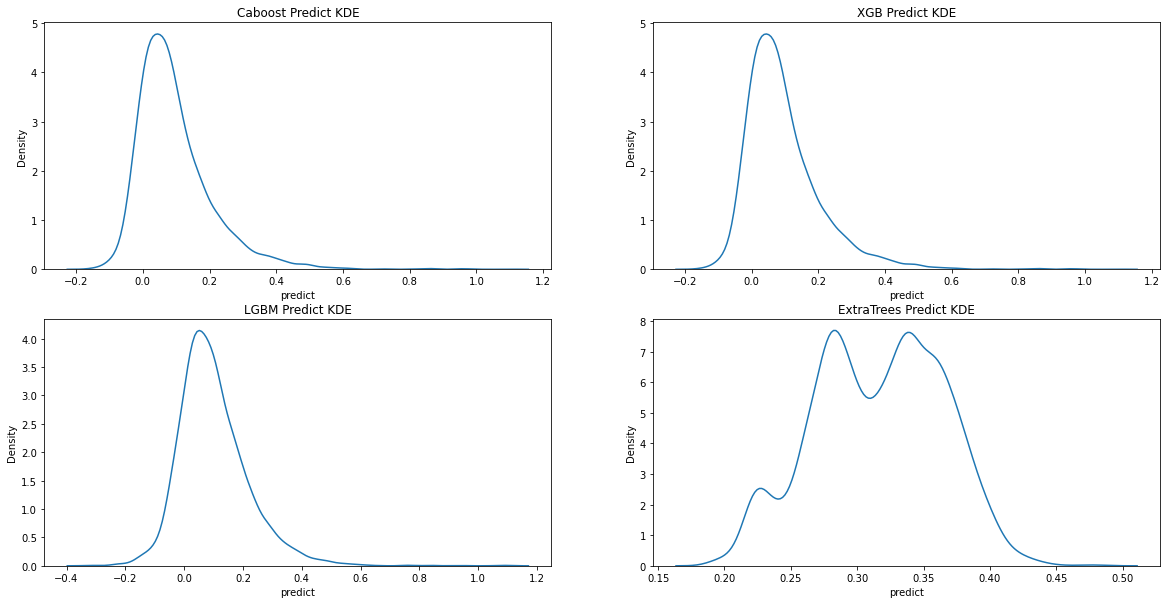

In [34]:
# Visualize target predict
#cb_pred = pd.DataFrame({'predict':tune_cb_reg_pred})
xgb_pred = pd.DataFrame({'predict':tune_xgb_reg_pred})
lgbm_pred = pd.DataFrame({'predict':tune_lgbm_reg_pred})
et_pred = pd.DataFrame({'predict':tune_et_reg_pred})

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.kdeplot(xgb_pred.predict)
plt.title('Caboost Predict KDE')

plt.subplot(2,2,2)
sns.kdeplot(xgb_pred.predict)
plt.title('XGB Predict KDE')

plt.subplot(2,2,3)
sns.kdeplot(lgbm_pred.predict)
plt.title('LGBM Predict KDE')

plt.subplot(2,2,4)
sns.kdeplot(et_pred.predict)
plt.title('ExtraTrees Predict KDE')

plt.show()

In [37]:
# target predict's describe
print(xgb_pred.predict.describe(), lgbm_pred.predict.describe(),et_pred.predict.describe())

count    6041.000000
mean        0.095882
std         0.112902
min        -0.167020
25%         0.020494
50%         0.072339
75%         0.143331
max         1.096620
Name: predict, dtype: float64 count    6041.000000
mean        0.100097
std         0.118383
min        -0.335423
25%         0.023911
50%         0.082565
75%         0.160211
max         1.108808
Name: predict, dtype: float64 count    6041.000000
mean        0.316022
std         0.048377
min         0.188908
25%         0.280005
50%         0.318443
75%         0.354358
max         0.485372
Name: predict, dtype: float64


In [40]:
# target predict 8.5% raw print by Model
#print(cb_pred.predict.sort_values(ascending = False).iloc[510:521])
print(xgb_pred.predict.sort_values(ascending = False).iloc[510:521])
print(lgbm_pred.predict.sort_values(ascending = False).iloc[510:525])
print(et_pred.predict.sort_values(ascending = False).iloc[510:521])

4050    0.255770
1341    0.255704
3444    0.255697
4533    0.255433
287     0.255131
1944    0.255005
4228    0.254760
4828    0.254731
830     0.254719
3081    0.254625
3956    0.254620
Name: predict, dtype: float32
1803    0.265039
2395    0.265027
1018    0.264801
3676    0.264684
3644    0.264582
2414    0.264503
2740    0.264365
2360    0.264323
4140    0.264164
5070    0.264066
5958    0.264064
4278    0.263334
5256    0.263234
3088    0.263227
2794    0.262410
Name: predict, dtype: float64
1188    0.380385
5466    0.380295
4278    0.380286
3984    0.380222
1351    0.380221
4662    0.380204
350     0.380187
2952    0.380173
5772    0.380119
1568    0.380100
2801    0.380026
Name: predict, dtype: float64


In [41]:
# Transform predict by Threshold
#cb_trans_reg_pred = np.array([0 if i < * else 1 for i in tune_cb_reg_pred])
xgb_trans_reg_pred = np.array([0 if i < 0.255 else 1 for i in tune_xgb_reg_pred])
lgbm_trans_reg_pred = np.array([0 if i < 0.264 else 1 for i in tune_lgbm_reg_pred])
et_trans_reg_pred = np.array([0 if i < 0.3802 else 1 for i in tune_et_reg_pred])

## Saving Task2 Model

In [39]:
# Saving Model
#joblib.dump(tune_cb_reg, 'model_save/tuning/task1_xxx_clf_task2_cb_reg.pkl')
joblib.dump(tune_xgb_reg, 'model_save/tuning/task1_cb_clf_task2_xgb_reg.pkl')
joblib.dump(tune_lgbm_reg, 'model_save/tuning/task1_cb_clf_task2_lgbm_reg.pkl')
joblib.dump(tune_et_reg, 'model_save/tuning/task1_cb_clf_task2_rt_reg.pkl')

['model_save/tuning/task1_cb_clf_task2_rt_reg.pkl']

## to_csv Submission

In [42]:
#pd.DataFrame({'ID': test_id, 'Y_LABEL': cb_trans_reg_pred}).to_csv('predict/modeling/xx_clf_cb_reg_\\\.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': xgb_trans_reg_pred}).to_csv('predict/modeling/cb_clf_xgb_reg_255.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': lgbm_trans_reg_pred}).to_csv('predict/modeling/cb_clf_lgbm_reg_264.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': et_trans_reg_pred}).to_csv('predict/modeling/cb_clf_et_reg_3802.csv', index=False)